# Metaheuristic Algorithms
Following sections try some techniques from stochasitic optimization, also known as *metaheuristics*.

In [1]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from alg import *
from utils import *

<AxesSubplot:xlabel='#resources', ylabel='min. makespan'>

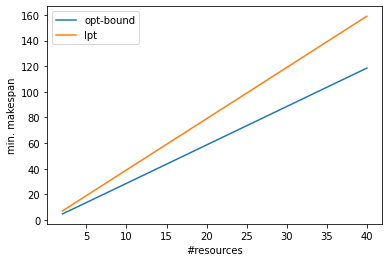

In [2]:
num_trials = 5
max_iters = 1000

resources = [2, *range(5, 45, 5)]
problem_instances = [(R, suboptimal_instance(R)) for R in resources]

def eval_lpt(R, p):
    _, m, r, = lpt(R, p)
    return m / r, m

lpt_df = pd.DataFrame(data=(eval_lpt(R, p) for R, p in problem_instances), index=resources, columns=['opt-bound', 'lpt'])
lpt_df.plot.line(xlabel='#resources', ylabel='min. makespan')

## Simulated Annealing

### Sanity check
Note that the optimal value for this instance is 9.

In [3]:
_, makespan = anneal(R=3, p=[5, 5, 4, 4, 3, 3, 3])
makespan

9.0

### SA evaluation
Comparison of the solution quality between SA and LPT on problem instances for which LPT is known to be sub-optimal.

Because SA is stochastic algorithm we take the mean value evaluated on `num_trials` per problem instance. Futhermore, each run uses `max_iters`.

Finally, SA is evaluated for each of the following *tweak* operators:
1. `vec_tweak` - for each task re-assign it to random resource with probabilyty `1/n` (`n` is no. tasks)
1. `point_tweak` - pick a task at random and assign it to random resource
1. `swap_tweak` - pick two tasks at random and swap the resources they are assigned to
each operator is then used with/witout fitness penalty `#unused resources * M` where `M` is some big-enough constant (marked with P).

In [4]:
def sa_makespan(R, p, tweak, penalize):
    _, m = anneal(R, p, tweak, max_iters, penalize=penalize)
    return m

def evaluate_sa(tweak, penalize):
    for R, p in problem_instances:
        # mean makespan
        yield sum(sa_makespan(R, p, tweak, penalize) for _ in range(num_trials)) / num_trials

In [5]:
tweak_df = pd.DataFrame({tweak.__name__: evaluate_sa(tweak, penalize=False) for tweak in [vec_tweak, point_tweak, swap_tweak]}, index=resources)
tweak_df = pd.concat([lpt_df, tweak_df], axis=1)
tweak_df

,opt-bound,lpt,vec_tweak,point_tweak,swap_tweak
2,4.666667,7.0,6.0,6.0,6.6
5,13.571429,19.0,17.0,16.4,20.0
10,28.536585,39.0,41.2,39.6,44.6
15,43.524590,59.0,68.4,67.6,78.8
20,58.518519,79.0,103.0,97.0,114.0
25,73.514851,99.0,131.8,127.4,159.2
30,88.512397,119.0,161.6,168.8,193.2
35,103.510638,139.0,205.6,203.8,223.6
40,118.509317,159.0,239.6,243.4,269.4


<AxesSubplot:xlabel='#resources (R)', ylabel='min. makespan (mean for SA)'>

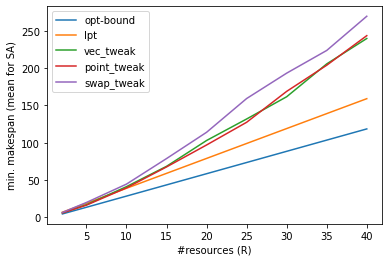

In [6]:
tweak_df.plot.line(xlabel='#resources (R)', ylabel='min. makespan (mean for SA)')

Now let's try one of the better tweak operators with a penalty to solution quality. This penalty is equal to `#unused resources * M` where `M` is some big-enough constant (e.g. `M = sum(p)`).

<AxesSubplot:xlabel='#resources (R)', ylabel='mean min. makespan (vec_tweak)'>

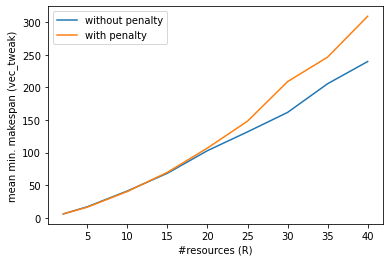

In [7]:
tweak_penalty_df = pd.DataFrame(
    {
        'without penalty': tweak_df['vec_tweak'],
        'with penalty': evaluate_sa(tweak=vec_tweak, penalize=True),
    },
    index=resources,
)
tweak_penalty_df.plot.line(xlabel='#resources (R)', ylabel='mean min. makespan (vec_tweak)')

## Evolutionary algorithms

### Sanity check
Note that the optimal value for this instance is 9.

In [8]:
_, makespan = evolve(R=3, p=[5, 5, 4, 4, 3, 3, 3], mate=two_point_crossover, mutate=mutation(vec_tweak, R=3))
makespan

9.0

### EA evaluation
Comparison of the solution quality between EA and LPT on problem instances for which LPT is known to be sub-optimal.

Because EA is stochastic algorithm we take the mean value evaluated on `num_trials` per problem instance. Futhermore, each run uses `max_iters`.

Finally, EA uses `vec_tweak` as the mutation operator, `two_point_crossover` as the mating operator and we run it for 
* varying population sizes: 10, 100
* with/witout fitness penalty `#unused resources * M` where `M` is some big-enough constant (marked with P)

In [9]:
def ea_makespan(R, p, pop_size, penalize):
    _, m = evolve(
        R=R,
        p=p,
        mate=two_point_crossover,
        mutate=mutation(vec_tweak, R),
        pop_size=pop_size,
        max_iters=max_iters,
        penalize=penalize,
    )
    return m

def evaluate_evolve(pop_size, penalize):
    for R, p in problem_instances:
        # mean makespan
        yield sum(ea_makespan(R, p, pop_size, penalize) for _ in range(num_trials)) / num_trials

In [10]:
evolve_df = pd.DataFrame({f'evolve-{pop_size}': evaluate_evolve(pop_size, penalize=False) for pop_size in [10, 100]}, index=resources)
evolve_df = pd.concat([lpt_df, evolve_df], axis=1)

<AxesSubplot:xlabel='#resources (R)', ylabel='min. makespan (mean for EA)'>

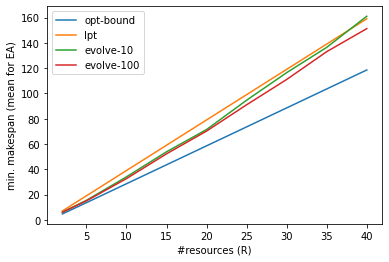

In [11]:
evolve_df.plot.line(xlabel='#resources (R)', ylabel='min. makespan (mean for EA)')

Similarly to SA, let's check if using a penalty for unused resources helps to find better schedules.

<AxesSubplot:xlabel='#resources (R)', ylabel='min. makespan (mean for EA; pop=10)'>

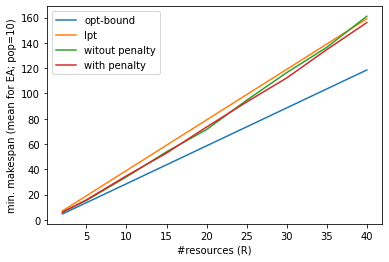

In [12]:
penalty_df = pd.DataFrame(
    {
        'witout penalty': evolve_df['evolve-10'],
        'with penalty': evaluate_evolve(pop_size=10, penalize=True),
    },
    index=resources,
)
penalty_df = pd.concat([lpt_df, penalty_df], axis=1)
penalty_df.plot.line(xlabel='#resources (R)', ylabel='min. makespan (mean for EA; pop=10)')